# Permutation Channel Importance

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import random
import glob
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

# Load python files
import sys
sys.path.append('../')

from utils.datasets import ImageDataset, SegmentationDataset

## PCI for Multispectral Data

In [2]:
# Load paths
paths = glob.glob('../../data/LICS/test/*')
print(len(paths))

100


In [3]:
# Create dataset object
lics_dataset = SegmentationDataset(paths)

# Load first instance
bands, target = lics_dataset.__getitem__(3)

In [4]:
# We have 7 spectral bands
bands.shape

torch.Size([7, 256, 256])

In [5]:
# Shuffle the nir band
nir = bands[3]

nir = np.asarray(nir)
nir = nir.ravel()
np.random.shuffle(nir)

nir.resize(256,256)
bands[3] = torch.tensor(nir)

Figure saved to /Users/conorosullivan/Documents/XAI/lics_channels.pdf


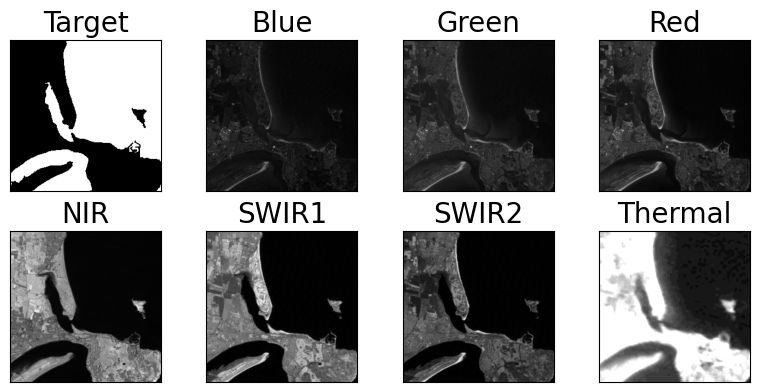

In [5]:
# Band names
band_names = {0: 'Blue', 1: 'Green', 2: 'Red', 3: 'NIR', 4: 'SWIR1', 5: 'SWIR2', 6: 'Thermal'}

fig, axs = plt.subplots(2, 4, figsize=(8, 4))
axs = axs.flatten()

# Plot target
axs[0].imshow(target[1], cmap='gray')
axs[0].set_title('Target')
axs[0].set_xticks([])
axs[0].set_yticks([])

# Plot bands
for i in range(7):
    axs[i+1].imshow(bands[i], cmap='gray')
    axs[i+1].set_title(band_names[i])
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

In [ ]:
# Load simpleCNN model trained on SIVE dataset
model = torch.hub.load("conorosully/coastal-segmentation-models",
                                    "finetuned_lics")
# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)
model.eval()

Downloading: "https://github.com/conorosully/coastal-segmentation-models/zipball/main" to /Users/conorosullivan/.cache/torch/hub/main.zip


U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [7]:
# Make a prediction
input = bands.to(device)
input = input.unsqueeze(0)
output = model(input)

print(target.shape)
print(output.shape)

torch.Size([2, 256, 256])
torch.Size([1, 2, 256, 256])


In [8]:
# Get the water mask
target_water = np.argmax(target, axis=0)

# Get the predicted water mask
output = output.cpu().detach().numpy().squeeze()
output = np.argmax(output, axis=0)

Figure saved to /Users/conorosullivan/Documents/XAI/lics_prediction.pdf


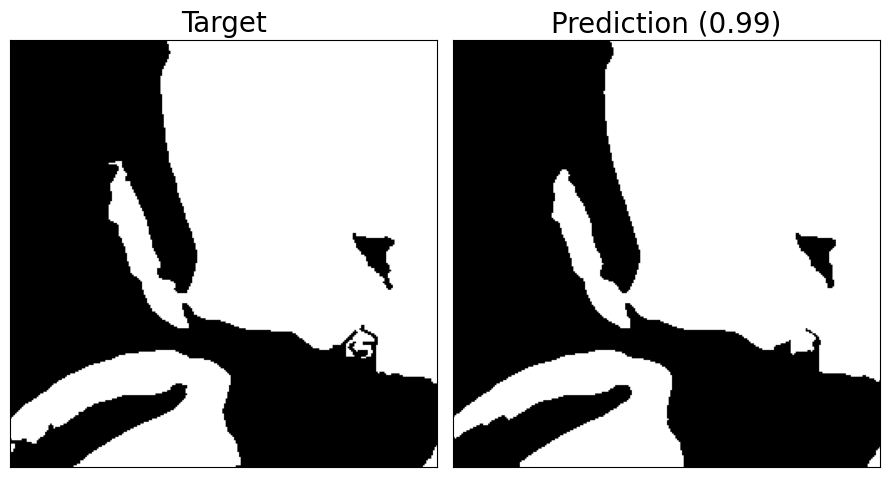

In [9]:
# Plot the prediction
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(target_water, cmap='gray')
axs[0].set_title('Target', fontsize=16)

axs[1].imshow(output, cmap='gray')

accuracy = np.mean(np.array(target_water == output))
accuracy = round(accuracy, 3)
axs[1].set_title(f'Prediction ({accuracy})', fontsize=16)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# PCI from scratch

In [10]:
def performance_metric(targets, predictions, type='segmentation'):
    """Calculate the performance metric for the model"""

    targets = np.array(targets)
    predictions = np.array(predictions)

    if type == 'segmentation':
        # Calculate average accuracy
        accuracy_list = []
        for t,p in zip(targets, predictions):
            accuracy = np.mean(t == p)
            accuracy_list.append(accuracy)

        metric = np.mean(accuracy_list)
    if type == 'classification':
        # Calculate accuracy
        metric = np.mean(targets == predictions)


    return metric

In [11]:
def shuffle_channel(img, channel):
        """Shuffle a given channel of an image
            img: tensor, image to shuffle with shape (batch, channels, height, width)
            channel: int, channel to shuffle"""

        # Get size of the image
        size_x = img.shape[2]
        size_y = img.shape[3]

        # Flatten the channel
        perm_img = img.to('cpu').detach().numpy()
        perm_channel = perm_img[0][channel]
        perm_channel = perm_channel.ravel()

        # Shuffle the channel
        random.shuffle(perm_channel)
        perm_channel.resize(size_x,size_y)
        perm_img[0][channel] = perm_channel

        #Convert to tensor
        perm_img = torch.tensor(perm_img)

        return perm_img

In [12]:
def get_permuted_performance(model, dataset, channel=-1, type='segmentation'):
    """Calculate the performance metric for the model with permuted data"""

    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()

    targets = []
    outputs = []

    for image, target in iter(data_loader):

        # Format target
        target = target.numpy().squeeze()
        target = np.argmax(target, axis=0)

        # Permuted image
        if channel != -1:
            image = shuffle_channel(image, channel)

        # Get prediction
        image = image.to(device)
        output = model(image)

        output = output.cpu().detach().numpy().squeeze()
        output = np.argmax(output, axis=0)

        # Append to list
        targets.append(target)
        outputs.append(output)

    metric = performance_metric(targets, outputs, type=type)

    return metric

In [13]:
# Get baseline performance
baseline = get_permuted_performance(model, lics_dataset, channel=-1, type='segmentation')
print(f'Baseline accuracy: {np.round(baseline,3)}')

Baseline accuracy: 0.985


In [14]:
# Get nir performance
nir = get_permuted_performance(model, lics_dataset, channel=3, type='segmentation')
print(f'NIR accuracy: {np.round(nir,3)}')
print(f'PCI: {np.round(baseline - nir,3)}')

NIR accuracy: 0.606
PCI: 0.38


In [15]:
pci_scores = []

# Repeat for all channels
for channel in tqdm([0,1,2,3,4,5,6]):
    # Repeate the calculation 3 times
    metrics = []
    for r in range(3):
        metric = get_permuted_performance(model, lics_dataset, channel=channel, type='segmentation')
        metrics.append(metric)

    # Calculate PCI
    pci = baseline - np.mean(metrics)
    pci_scores.append(pci)

100%|██████████| 7/7 [04:28<00:00, 38.38s/it]


Figure saved to /Users/conorosullivan/Documents/XAI/PCI_spectral_scores.pdf


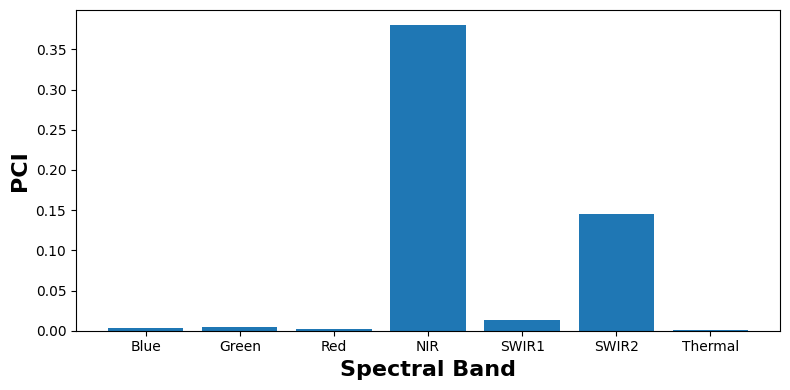

In [16]:
# Plot the PCI scores
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(band_names.values(), pci_scores)

ax.set_ylabel('PCI', fontsize=16, fontweight='bold')
ax.set_xlabel('Spectral Band', fontsize=16, fontweight='bold')